# Lab-2 Quantum Error Correction

## Part 0: Setup

Please make sure you have the requirment installed correctly by running the following cell

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram
from collections import Counter
from qiskit.circuit import Gate

## Part 1: The Repetition Code [40 Points]

In this first part you will construct the repetition code. The repetition code is one of the most basic quantum error correction codes. Like the classical repetition code, it uses redundancy to protect information from noise.

The basic scheme is that we use 3 entangled data qubits instead of one. Then the detection of errors can be performed through checking if the parities of the qubits agree or no.



### Question 1   [20 Points]

a. Following the notes from the lecture, please construct a circuit 3-qubit repitition code. 


In [1]:
def bit_flip_repetition_code_3_qubits_entangle():
    #TODO
    return qc     

def bit_flip_repetition_code_3_qubits_measure_syndrome(error_injection_circuit = None):
    #TODO
    # Measure the syndromes
    return qc 

def bit_flip_repetition_code_3_qubits(error_injection_circuit = None):
    #TODO
    # Create a Quantum Circuit acting on a quantum register of three qubits

    # Encode the 3 data qubits

    #Add Error Injection Circuit

    # Measure the Syndrome

    return qc

def bit_flip_repetition_code_3_qubits_with_error(qubit_to_flip = None):
    #TODO
    return qc


b. Use your circuits above to find out what the measured syndrome will be for single bit-flip errors. Then create a dictionary that maps bitstrings corresponding to syndromes to the index qubit where the single bit-flip error occurred. Name your dictionary decoder.


In [2]:
#TODO
#Simulate the circuit

#Write a dictionary that will be your decoder, use -1 to indicate no error


c. To put it all together, write a circuit which will a 3-qubit repetition code entangled state, measure the syndrome, correct the error, and then unentangle to recover the original state. Your circuit will be composed with some single bit-flip error state and simulated to test its correctness.

In [5]:
def bit_flip_repetition_code_3_qubits_with_error_correction():
    #TODO
    #Create your syndrome extraction circuit

    #Correct the Error

    return qc

def bit_flip_repetition_code_3_qubits_disentangle():
    #TODO
    
    return qc  



### Question 2 [10 Points]

Following the same steps as in question 1, design a repitition code to correct single phase-flip errors.

In [6]:
def phase_flip_repetition_code_3_qubits_with_error_correction():
    #TODO
    #Create your syndrome extraction circuit

    return qc

def phase_flip_repetition_code_3_qubits_disentangle():
    #TODO
    # Create a Quantum Circuit acting on a quantum register of three qubits

    # Encode the 3 data qubits

    return qc  



### Question 3 [10 Points]

Test if your decoder still works correctly when more than one single bit-flip error is introduced in the 3-qubit repitition code. Following the same steps as in question 1, design a 5-qubit repitition code to correct two bit-flip errors.

In [104]:
#TODO Test if the error correction with 3 qubits works if more than a single error is present

def bit_flip_repetition_code_5_qubits_with_error_correction():
    #TODO
    return qc

def bit_flip_repetition_code_5_qubits_disentangle():
    #TODO
    return qc  


### Question 4 [10 Points]

Test if your decoder still works correctly when more than one single phase-flip error is introduced in the 3-qubit repitition code. Following the same steps as in question 1, design a 5-qubit repitition code to correct two phase-flip errors.

In [105]:
#TODO Test if the error correction with 3 qubits works if more than a single error is present

def phase_flip_repetition_code_5_qubits_with_error_correction():
    #TODO
    return qc

def phase_flip_repetition_code_5_qubits_disentangle():
    #TODO
    return qc  

### Question 5 [8 Points]

How do measurement errors affect the performance of the decoder? Write a circuit to analyze this question and justify it in your report.

In [2]:
#TODO Analyze how measurement errors affect the error correction scheme

## Part 2: Surface Codes [60 Points]

Repetition codes as we saw can completely correct single bit-flip and phase-flip errors. However, in real systems, both phase-flip and bit-flip errors occur simultaneously. Surface codes are a simple error correcting code that can be used to correct both types of errors at the same time. However, they are limited in the number of errors they can correct. We will implement a distance-3 error correcting code, meaning that our code should be able to correct 3 errors that occur at the same time. However, for the purposes of this lab, we will only consider single errors.


The process will be the same as in the prior part of the lab:
1. Construct the circuit for the code with the ancilla qubits for syndrome extraction.
2. Inject errors into our circuit systematically and determine what the syndromes will be
3. Use that information to construct a simple look up decoder that uses the syndrome to determine the error and correct it
4. Finally construct a complete error detecting and error correcting circuit


Surface codes are the state of the art today, although it is being slowly replaced by alternative codes


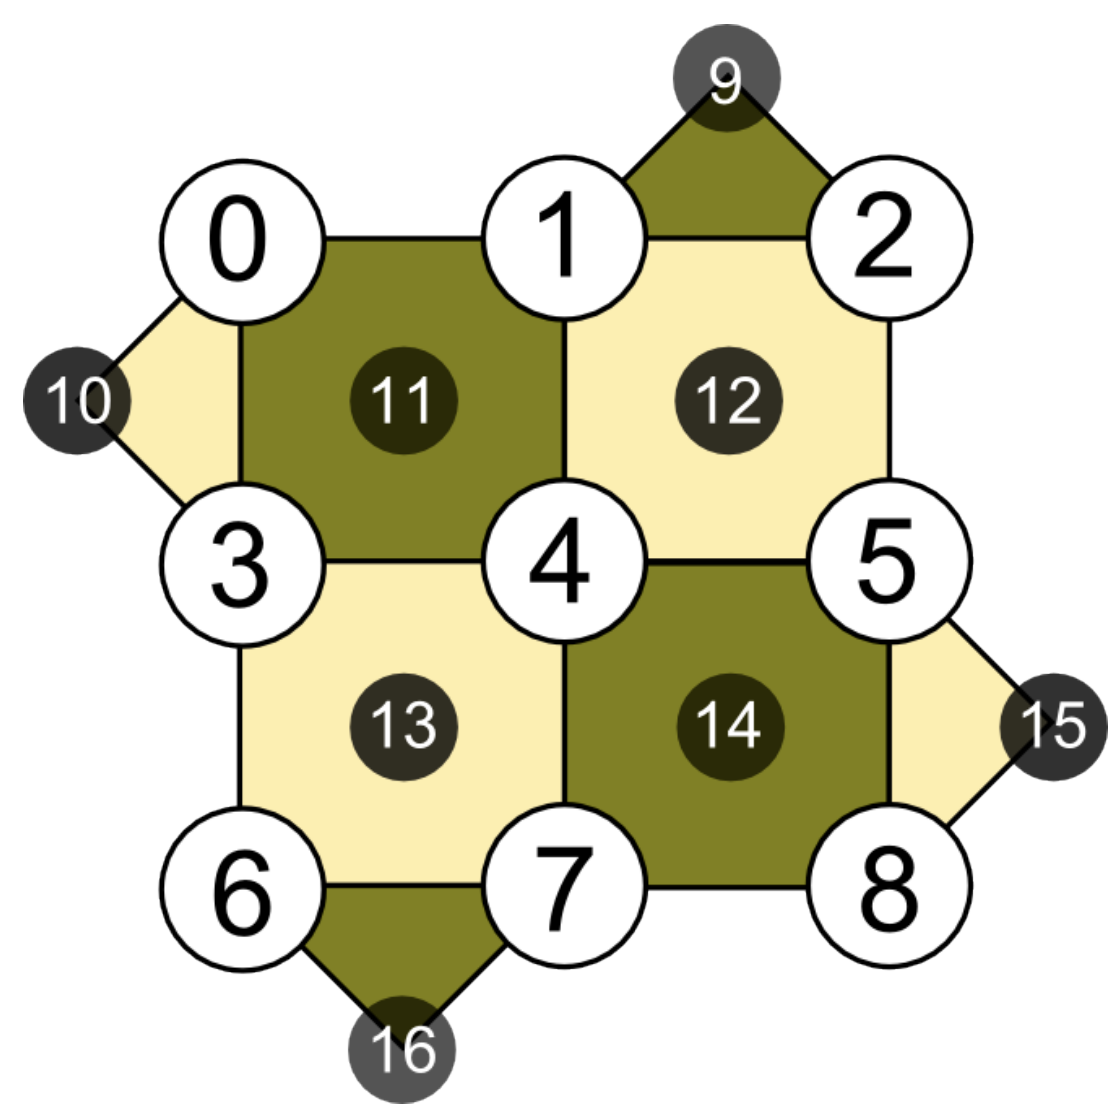

The diagram above can be read as follows. Each of the numbered circles is a qubit. Surface codes, unlike repetition codes, do not have a clear distinction between the parity qubits and the data qubits. What you should think about instead, is the logical qubit, represented by the entirety of the 9 qubits that are white circles. Each of the colored tiles is something known as a stabilizer or check. The checks here can be viewed as the ancilla qubits that we use to make a measurement. As with the repetition code we conduct entanglement measurements on these qubits by entangling them with their neighboring qubits. After entanglement we measure the ancilla qubit as we would normally and the measurements together make up our syndrome. Since the surface codes support both phase-flip and bit-flip errors the entanglements are either CNOT or CZ. Qubits on dark tiles correspond to X checks, i.e. ancilla qubits that are entangled using the CNOT Operation. Qubits on light tiles correspond to Z checks, i.e. ancilla qubits that are entangled using the CZ Operation.




### Question 1 [15 Points]

Construct a circuit to measure the syndrome as indicated in the diagram above.

In [7]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def rotated_surface_code(error_injection_circuit = None):
    # Initialize registers: 9 data qubits (d), 4 X-syndrome qubits (sx), 4 Z-syndrome qubits (sz)

    # Classical registers for the syndrome measurements

    # Create the quantum circuit

    # Prepare the X-syndrome measurements

    # Put X-syndrome qubits into superposition

    # Prepare X-syndrome stabilizers (CNOT gates entangle data qubits with X-syndrome qubits)

    # Prepare the Z-syndrome measurements
    # Prepare Z-syndrome stabilizers (CZ gates entangle data qubits with Z-syndrome qubits)

    # Put data qubits into superposition for Z-syndrome


    # Measure the syndrome qubits

    return qc



### Question 2 [15 Points]

Use the circuit you implmented above to create a decoder single bit-flip errors and another decoder for single phase-flip errors. Note that the errors are independent and can be decoded in parallel. You may put the decoders together if you wish.

In [108]:
#TODO
#Simulate the circuit

#Write a dictionary that will be your decoder, use -1 to indicate no error


### Question 3 [15 Points]

Congratulations your now ready to implement an error correction circuit. Using your decoder and your circuit please complete the following function which returns an error correcting circuit that detects and corrects single bit-flip or phase-flip errors. The code will be tested by prepending the circuit with the circuit that inserts a single error at an arbitrary data qubit.

In [111]:
def rotated_surface_code_with_error_correction(qubit_to_flip=None):
    #TODO
    return qc



### Question 4 [15 Points]

What about measurement errors? Add measurement errors to your syndrome extraction circuit right before extraction. Analyze how this changes the performance of your decoder and error correction.

In [110]:
#TODO Analyze how measurement errors affect the error correction scheme